## Setup

In [1]:
!pip install poetry

In [2]:
!pip install https://github.com/parulsethi/SMorph/releases/download/0.1.0/SMorph-0.1.0.tar.gz

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import smorph as sm
import pandas as pd
pd.set_option('display.max_rows', None)

In [5]:
# All 23 Morphological features' names which will be extracted from the images
sm.ALL_FEATURE_NAMES

('surface_area',
 'total_length',
 'avg_process_thickness',
 'convex_hull',
 'no_of_forks',
 'no_of_primary_branches',
 'no_of_secondary_branches',
 'no_of_tertiary_branches',
 'no_of_quatenary_branches',
 'no_of_terminal_branches',
 'avg_length_of_primary_branches',
 'avg_length_of_secondary_branches',
 'avg_length_of_tertiary_branches',
 'avg_length_of_quatenary_branches',
 'avg_length_of_terminal_branches',
 'critical_radius',
 'critical_value',
 'enclosing_radius',
 'ramification_index',
 'skewness',
 'coefficient_of_determination',
 'sholl_regression_coefficient',
 'regression_intercept')

In [6]:
# color to be used for each group
color_dict = {0: 'green', 1: 'red'}

# group labels
labels = {0: 'ctrl', 1: 'stab'}

# marker for each group to be used in PCA plot
markers = {0: 'o', 1: '^'}

contrast_ptiles = (2, 98)
threshold_method = sm.util.THRESHOLD_METHODS[6]
threshold_method

'yen'

## Start group analysis

In [7]:
# input the path to individual group folders (place them in SMorph)
groups_folders = ['Datasets/CTRLvsSTAB/control', 'Datasets/CTRLvsSTAB/stab']

In [8]:
groups = sm.Groups(groups_folders, image_type='confocal',
                   groups_crop_tech='manual', labels=labels,
                   contrast_ptiles=contrast_ptiles,
                   threshold_method=threshold_method,
                   shell_step_size=3, polynomial_degree=3,
                   save_features=True, show_logs=False)

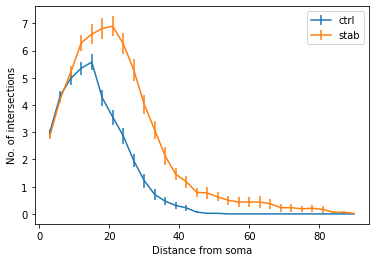

In [9]:
groups.plot_avg_sholl_plot(True)

Select out of 23 Morphological features on which you want to perform Principal Component Analysis

In [10]:
pca_features = list(sm.ALL_FEATURE_NAMES)

# Prune the Morphological features, if needed.
pca_features.remove('avg_process_thickness')
pca_features.remove('total_length')
pca_features.remove('ramification_index')

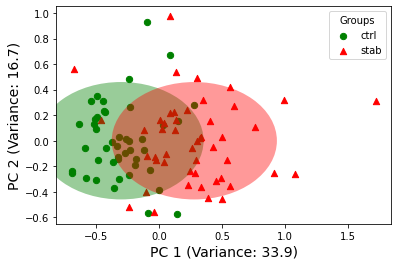

array([0.33852726, 0.1670284 , 0.12524832])

In [11]:
groups.pca(n_PC=3, color_dict=color_dict, markers=markers,
           save_results=True, on_features=pca_features)

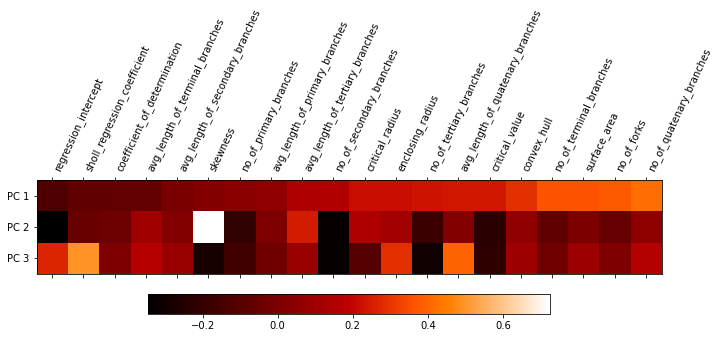

In [12]:
groups.plot_feature_significance_heatmap()

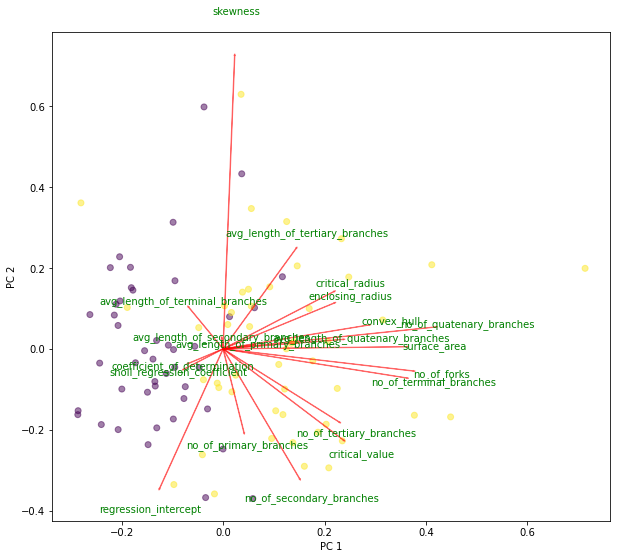

In [13]:
groups.plot_feature_significance_vectors()

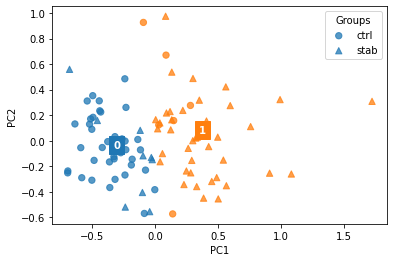

k = 2 clusters (0, ..., 2) with Variance Ratio = 67.4255878482137
seed = 38
Using principal components
Distribution in clusters (rows represent clusters):


,ctrl,stab
0,39,9
1,6,39


In [14]:
cluster_centers, clustered_data, dist = groups.get_clusters(k=2, use_features=False,
                                                            n_PC=2, plot='scatter')
print('Distribution in clusters (rows represent clusters):')
dist

In [15]:
cluster_centers

,PC 1,PC 2,cluster
0,-0.330207,-0.055313,0
1,0.352221,0.059000,1


## Individual histograms

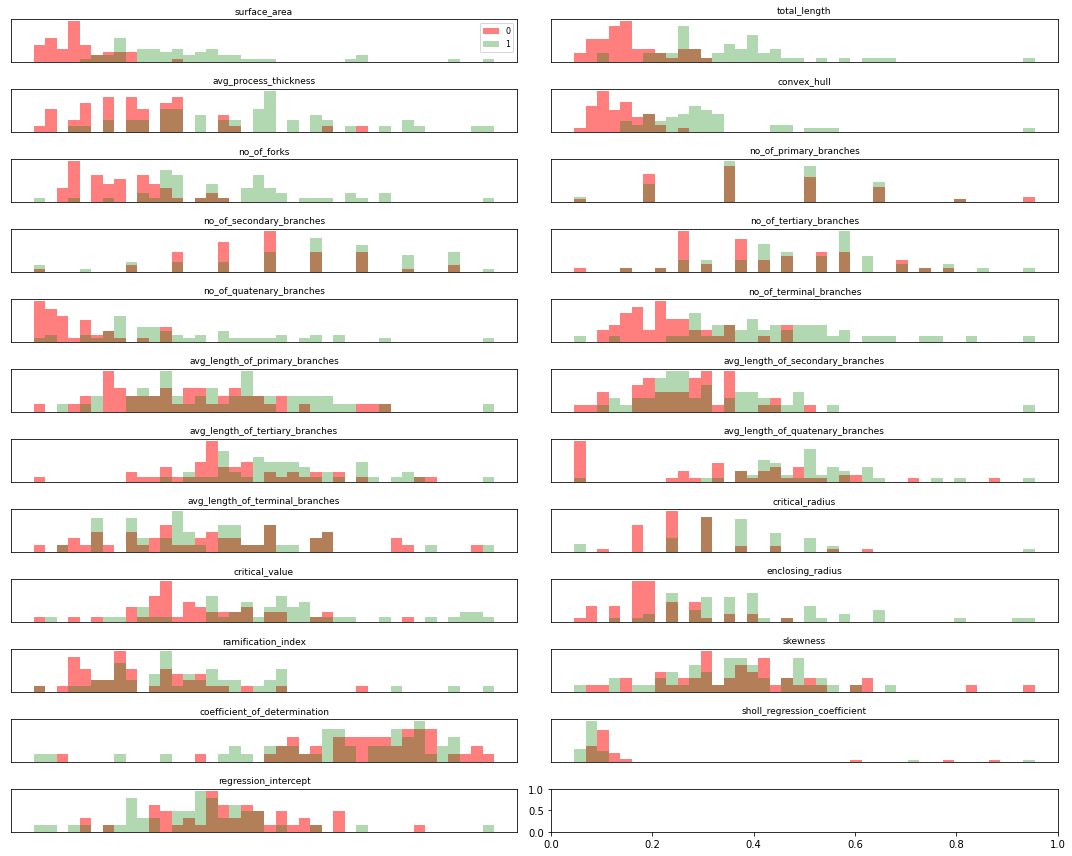

In [16]:
groups.plot_feature_histograms()